**21**. Simple hierarchical modeling:
The file *pew_research_center_june_elect_wknd_data.dta3* has data from Pew Research
Center polls taken during the 2008 election campaign. 
Your task is to estimate the percentatge of the (adult) population in each state (excluding
Alaska and Hawaii) who label themselves as ‘very liberal,’ replicating the procedure that
was used in Section 2.8 to estimate cancer rates. But you do not need to make maps;
it will be enough to make scatterplots, plotting the estimate vs. Obama’s vote share in
2008 (data available at *2008ElectionResult.csv*).
Make the following four graphs on a single page:

**(a)** Graph proportion liberal in each state vs. Obama vote share—that is, a scatterplot
using the two-letter state abbreviations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from bokeh.io import show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d, BoxAnnotation

output_notebook()

Loading BokehJS ...

In [2]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [3]:
df = pd.read_stata('pew_research_center_june_elect_wknd_data.dta')
election = pd.read_csv("2008ElectionResult.csv")
states_out = ['alaska', 'hawaii']

In [4]:
lib = (df[df['ideo'].notnull()]
                    .loc[:, ['state', 'ideo']]
                    .loc[df['ideo'] == 'very liberal']
                    .groupby('state')
                    .count()
                    .query('state not in @states_out').reset_index(drop = True)
      )

In [5]:
n = (df[df['ideo'].notnull()]
                    .loc[:, ['state', 'ideo']]
                    .groupby('state')
                    .count()
                    .query('state not in @states_out').reset_index(drop = True)
    )

In [6]:
election = (election.assign(abb = election['state'].replace(us_state_to_abbrev), 
                           state = election['state'].str.lower().replace({'district of columbia':'washington dc'}),
                           obama_won = np.where(election['vote_Obama_pct'] > 50, 'yes', 'no')) 
                   .query('state not in @states_out').reset_index(drop = True) 
                   .assign(lib = lib, n = n, lib_prop = (lib / n) * 100)
           )

In [7]:
#election.head()

In [8]:
index_cmap = factor_cmap('obama_won', palette = ['red', 'blue'], factors = sorted(election.obama_won.unique()))
elec = ColumnDataSource(data = election)

In [9]:
p = figure(title = "Proportion of liberals vs Obama votes", 
           y_range = Range1d(0, 14), 
           x_range = Range1d(0, 100), 
           plot_width = 600, 
           plot_height = 500)
p.scatter('vote_Obama_pct','lib_prop',
          source = elec,
          line_color = 'white', 
          fill_alpha = 4, 
          fill_color = index_cmap, 
          size = 4)
labels = LabelSet(y = 'lib_prop', x = 'vote_Obama_pct', 
                  text = 'abb', 
                  level = 'glyph', 
                  text_font_size = '6pt', 
                  text_color = index_cmap,
                  x_offset=-6, y_offset=0, 
                  source=elec, 
                  render_mode='canvas')
p.yaxis.axis_label = 'Proportions of liberals in the survey'
p.xaxis.axis_label = 'Proportion of Obama votes'
low_box = BoxAnnotation(right = 50, fill_alpha = 0.1, fill_color = 'red')
high_box = BoxAnnotation(left = 50, fill_alpha = 0.1, fill_color = 'blue')
p.add_layout(low_box)
p.add_layout(high_box)
p.add_layout(labels)
show(p)

**(b)** Graph the Bayes posterior mean in each state vs. Obama vote share.

In [10]:
rate = np.mean(election['lib'] / election['n']) / np.var(election['lib'] / election['n'], ddof = 1)
shape = rate * np.mean(election['lib'] / election['n'])

In [11]:
x = np.linspace(0, 0.3, 100)
y = st.gamma.pdf(x, shape, scale = 1/rate)

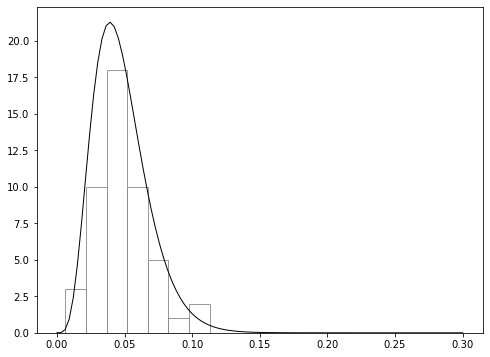

In [12]:
plt.figure(figsize = (8, 6))
plt.hist(election['lib']/election['n'], bins = 7, edgecolor = 'gray', facecolor = 'white', alpha = 0.8)
plt.plot(x, y, c = 'k', lw = 1);

In [13]:
election = election.assign(posterior_mean = ((shape + election['lib']) / (rate + election['n']))*100)

In [14]:
elec = ColumnDataSource(data = election)

In [15]:
p = figure(title = "Proportion of liberals vs Obama votes", 
           y_range = Range1d(0, 15), 
           x_range = Range1d(0, 100),
           plot_width = 600, 
           plot_height = 500)
p.scatter('vote_Obama_pct', 'posterior_mean',
          source = elec,
          line_color = 'white', 
          fill_alpha = 4, 
          fill_color = index_cmap,
          size = 4)
labels = LabelSet(y = 'posterior_mean', 
                  x = 'vote_Obama_pct', 
                  text = 'abb', 
                  level = 'glyph',
                  text_font_size = '6pt',
                  text_color = index_cmap,
                  x_offset = -6, 
                  y_offset = 0, 
                  source = elec, 
                  render_mode ='canvas')
p.yaxis.axis_label = 'Bayesian Mean of Proportion in Survey'
p.xaxis.axis_label = 'Proportion of Obama votes'
low_box = BoxAnnotation(right = 50, fill_alpha = 0.1, fill_color = 'red')
high_box = BoxAnnotation(left = 50, fill_alpha = 0.1, fill_color = 'blue')
p.add_layout(low_box)
p.add_layout(high_box)
p.add_layout(labels)
show(p)